# PC Price Regression 

## Problem Statement
> **Can we use machine learning to help PC buyers to check if it is a good or bad deal?**

### Problem Understanding 
Typically , when us consumers buy Personal Computers there's alot of options , and it is difficult to recognise which is a good or bad deal especially in singapore where sales hunting is very prominent . The process of cross validating with other sources is very reptitive and may cause losing deals. This is because in a PC there's many factors such as CPU , GPU, RAM , Storage ... just to name a few to evaluate the price of the PC.

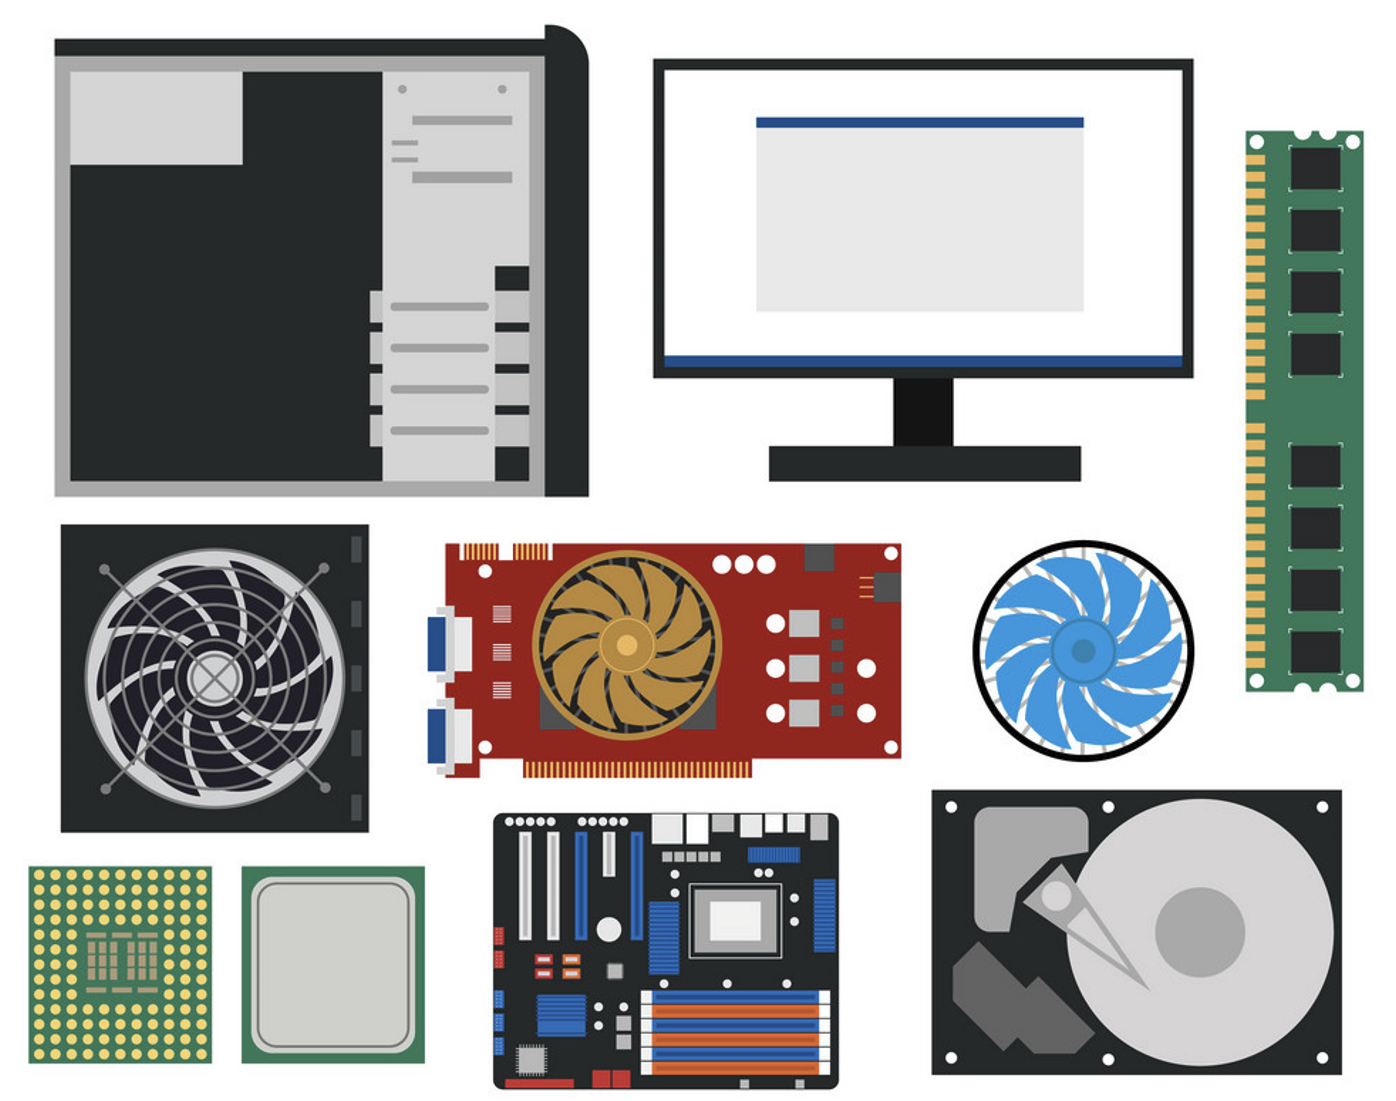



### General Knowledge

Typically in a computer the prices of components ranked is
1. CPU
2. GPU 
3. RAM 
4. Display
5. Storage

Hence our objective would be to :
- create a model that supplement consumers looking to buy a PC to make a better purchasing decision 
- extract insights on how important different factors affect PC prices 

### Evaulation Metrics
PC which stands for personal computer , so this model is most widely used for typical consumers . The need for an Professional Grade Personal Computer would be very rare . Which is why I have chosen MAE as my evaluation metrics.

### Mean Absolute Error
Mean absolute error is defined by 
$$
 MAE= \frac{\sum^n_{i=1}|y_i-\hat{y}_i|}{n}
$$
where $y_i$ is the actual value, and $\hat{y}_i$ is the predicted value of $y_i$. $n$ is the total number of examples evaluated.

I have chosen MAE as my primary evaluation metrics because 
- It is directly interpretable as the average error of our model
- It did not Square our error , it does not penalize our model when there are extreme outliers 
- shows how our model perform on a typical laptop.

### Benchmark 
For this test there's no inherent benchmark , so our aim would be to achieve as low of an MAE as possible while remain having a high r2 value

# Questions

1. The prediction task is define by using different compoents in the computer like cpu , gpu  ram , storage and determine whats the price of the computer  .The target variable would be the price of the computer in dollars.

2. In this particular alot of preprocessing have to be done in order to extract useful informatiom from the data. Some of these include extracting ssd , hdd , etc  from the storage column . extracting resolution from screen specs just to name a few , SOme convertions have to be done to more accurately represent the relationship between the variables such as representing RAM as numerical instead of categorical . 

3. For the target feature price , it is skewed to the right . so i have to use transformtarget regressor to apply a logarithm scaling to turn it into guassian distirbution . I had discovered and used a new type of categorical encoder for features with high cardinality called binary encoder which helps me reduce the dimension and training time . 

4. Just like classification ,  Firstly , i do a mass training of algorithm to see which models have a high Cross-validation score right off the bat.Then i select the top 2 algorithm and tune it's hyperparameters to see which model gives the best MAE score and looking at the learning curve to determine if it's overfitting or underfitting. Then i picked the model with the best MAE score and use it for the final evaluation.

5. In this scenario , my default parameters for decision Tree regressor worked very well without any hyper parameter tunning and when i plotted the learning curve it shows no sign of overfitting although usually the default parameter results in overfitting. So the next step is to improve it's ability to generalise by reducing the max depth without losing out on much performance and ended up with a cross validation score of 15. For the other model i tunned KNN regressor , it started off with a worse MAE score due to underfitting . So I increased the n neighbours .

6. I Evaluated the system using MAE score because in this case because firstly it is directly interpretable and since the metrics does not square the error , it does not heavily penalize our model when there's extreme outliers such as the extremely high end Workstation desktop present in the dataset.

7. The stupid baseline will always predict the average so the MAE for it is 1400.65 which is significantly higher than my final model of 15.71.

8. The error that this model makes is mostly clustered at prices 6000 to 8000 which are considered extreme values as it only contains 6% of the total computers.

9. The features that model considers important is X_resolution followed by brand and RAM which is different from what we usually consider as important

# Flow of analysis 

1. Features extraction + preprocessing because data currently is all in categorical formate features could be extracted.
2. Exploratory Data Analysis to check for patterns and internal correlation 
3. Feature selection 
4. Features encoding 
5. Evaluation of module 
6. Hyperparameter tunning
7. Evaluation of final model
8. Conclusion 


In [405]:
import numpy as np
import pandas as pd
from sklearn import datasets
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.compose import ColumnTransformer

# PC data context 
Based on the CPU in this dataset it is collected in early 2017 
price of cpu back then have a trend


In [406]:
data = pd.read_csv("pc_data (regression).csv")

# Check duplicates in Data

In [407]:
bool_series = data.duplicated(keep=False)
data[~bool_series]

Product ID   Brand                Type  Screen Size  \
0               0   Apple           Ultrabook         13.3   
1               1   Apple           Ultrabook         13.3   
2               2      HP            Notebook         15.6   
3               3   Apple           Ultrabook         15.4   
4               4   Apple           Ultrabook         13.3   
...           ...     ...                 ...          ...   
15315       15315  Lenovo  2 in 1 Convertible         14.0   
15316       15316  Lenovo  2 in 1 Convertible         13.3   
15317       15317  Lenovo            Notebook         14.0   
15318       15318      HP            Notebook         15.6   
15319       15319    Asus            Notebook         15.6   

                                     Screen Specs  \
0              IPS Panel Retina Display 2560x1600   
1                                        1440x900   
2                               Full HD 1920x1080   
3              IPS Panel Retina Display 2880x1800   
4              IPS Panel Retina Display 2560x1600   
...                                           ...   
15315   IPS Panel Full HD / Touchscreen 1920x1080   
15316  IPS Panel Quad HD+ / Touchscreen 3200x1800   
15317                                    1366x768   
15318                                    1366x768   
15319                                    1366x768   

                                        CPU   RAM            Hard Disk  \
0                      Intel Core i5 2.3GHz   8GB            128GB SSD   
1                      Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
2                Intel Core i5 7200U 2.5GHz   8GB            256GB SSD   
3                      Intel Core i7 2.7GHz  16GB            512GB SSD   
4                      Intel Core i5 3.1GHz   8GB            256GB SSD   
...                                     ...   ...                  ...   
15315            Intel Core i7 6500U 2.5GHz   4GB            128GB SSD   
15316            Intel Core i7 6500U 2.5GHz  16GB            512GB SSD   
15317  Intel Celeron Dual Core N3050 1.6GHz   2GB   64GB Flash Storage   
15318            Intel Core i7 6500U 2.5GHz   6GB              1TB HDD   
15319  Intel Celeron Dual Core N3050 1.6GHz   4GB            500GB HDD   

                                GPU Operating System  Weight   Price ($)  
0      Intel Iris Plus Graphics 640            macOS  1.37kg  3568.93416  
1            Intel HD Graphics 6000            macOS  1.34kg  2394.77616  
2             Intel HD Graphics 620            No OS  1.86kg  1531.80000  
3                AMD Radeon Pro 455            macOS  1.83kg  6759.76680  
4      Intel Iris Plus Graphics 650            macOS  1.37kg  4804.79040  
...                             ...              ...     ...         ...  
15315         Intel HD Graphics 520       Windows 10   1.8kg  1706.40200  
15316         Intel HD Graphics 520       Windows 10   1.3kg  4000.10600  
15317             Intel HD Graphics       Windows 10   1.5kg   616.82600  
15318            AMD Radeon R5 M330       Windows 10  2.19kg  2042.06600  
15319             Intel HD Graphics       Windows 10   2.2kg   989.78600  

[15320 rows x 12 columns]

### No Duplicates of pc is found


## Useful data that could be extracted in screen specs features.
1. display x and y resolution 
2. IPS or not 
3. Touchscreen or not 
4. CPU model, CPU manufactuer , CPU gigahertz 
5. possibily the GPU manufactuer and model

### In the next part of anlysis i will determine is it is necessary

## Extraction relevant futures from Display Resolution

- X and y dimension of display 
- whether is it IPS or Touchscreen as data that have these features will generally cost more

In [408]:
#finding the x_res and y_res from screen resolution
data['X_res'] = data['Screen Specs'].apply(lambda x: x.split()[-1].split("x")[0])
data['Y_res'] = data['Screen Specs'].apply(lambda x: x.split()[-1].split("x")[1])
#convert to numeric
data['X_res'] = data['X_res'].astype('int')
data['Y_res'] = data['Y_res'].astype('int')

In [409]:
data['IPS'] = data['Screen Specs'].apply(lambda x:1 if 'IPS' in x else 0)
data['Touchscreen'] = data['Screen Specs'].apply(lambda x:1 if 'Touchscreen' in x else 0)

## Convert RAM and Weight into Numerical

In [410]:
data['RAM'] = data['RAM'].str.replace("GB", "")
data['Weight'] = data['Weight'].str.replace("kg", "")
data['RAM'] = data['RAM'].astype('int32')
data['Weight'] = data['Weight'].astype('float32')

## Extracting information on CPU 
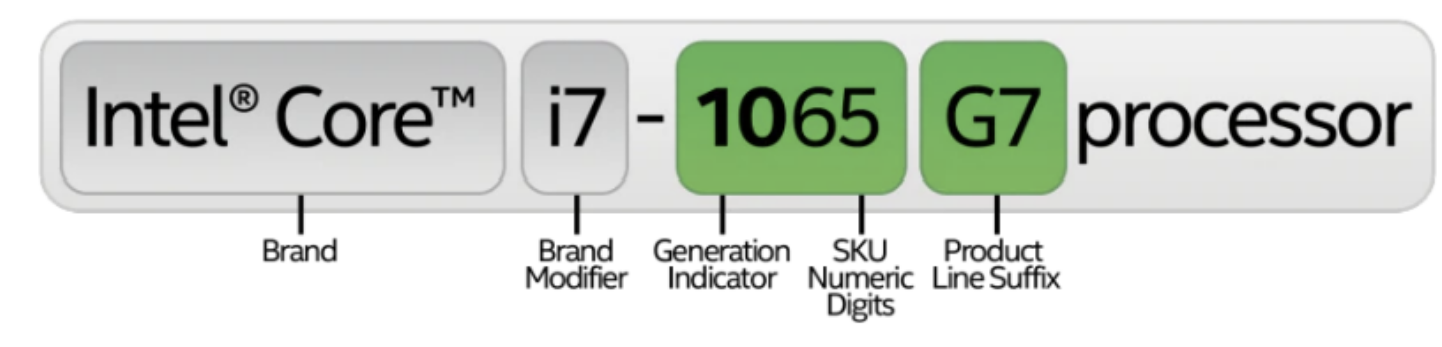

Attached above is a general idea of how cpu models looked like

In [411]:
data['CPU_brand'] = data['CPU'].apply(lambda x: x.split()[0])

In [412]:
ok = []
for i in data['CPU']:
    if i.split()[1] not in ok:
        ok.append(i.split()[1])
print(ok)

['Core', 'A9-Series', 'Atom', 'E-Series', 'A6-Series', 'Celeron', 'Ryzen', 'Pentium', 'FX', 'Xeon', 'A10-Series', 'A8-Series', 'A12-Series', 'A4-Series', 'Cortex']


In [413]:
data['cpu models'] = data['CPU'].apply(lambda x: x.split()[1])

In [414]:
data.groupby("cpu models").mean()

Product ID  Screen Size        RAM    Weight    Price ($)  \
cpu models                                                               
A10-Series  7518.833333    16.166667   6.000000  2.345000  1535.840707   
A12-Series  7797.791667    15.600000   8.250000  2.167500  1750.966477   
A4-Series   7910.666667    17.300000   4.000000  2.800000  1015.512667   
A6-Series   7461.838710    15.874194   4.774194  2.136452  1081.963561   
A8-Series   7729.666667    16.025000   6.000000  2.407500  1200.660667   
A9-Series   7597.280000    15.684000   4.960000  2.064000  1311.032182   
Atom        7626.444444    12.780556   3.555556  1.223611   858.748282   
Celeron     7755.927481    13.892366   3.748092  1.673817   858.180919   
Core        7655.186268    15.086053   9.035099  2.067946  3320.709924   
Cortex      8212.666667    12.300000   4.000000  1.150000  1761.432667   
E-Series    7409.960000    15.280000   3.840000  1.974000   822.839923   
FX          7539.166667    15.600000  12.000000  2.475000  2267.592667   
Pentium     7756.764045    14.974157   4.404494  2.046292  1165.222207   
Ryzen       7210.545455    17.300000  12.363636  3.213636  4589.621636   
Xeon        7524.166667    16.025000  18.000000  2.632500  9553.632667   

                  X_res        Y_res       IPS  Touchscreen  
cpu models                                                   
A10-Series  1827.666667  1028.000000  0.500000     0.000000  
A12-Series  1712.250000   963.000000  0.000000     0.000000  
A4-Series   1600.000000   900.000000  0.000000     0.000000  
A6-Series   1620.967742   911.612903  0.000000     0.000000  
A8-Series   1563.000000   879.000000  0.000000     0.000000  
A9-Series   1679.200000   944.400000  0.060000     0.000000  
Atom        1843.055556  1083.333333  0.472222     0.305556  
Celeron     1445.122137   815.816794  0.137405     0.103053  
Core        1950.924261  1101.780788  0.306650     0.161022  
Cortex      2400.000000  1600.000000  1.000000     1.000000  
E-Series    1432.480000   805.440000  0.000000     0.000000  
FX          1920.000000  1080.000000  0.500000     0.000000  
Pentium     1510.404494   849.303371  0.000000     0.067416  
Ryzen       1920.000000  1080.000000  0.272727     0.000000  
Xeon        2880.000000  1620.000000  0.500000     0.000000

# Reason for not using ordinal encoding for cpu models
Even thought cpu models is a ordinal cateogory, 
such as Xeon > Core > Pentium > Celeron > Atom , it is hard to order them due to 
there being 2 cpu manufactures. It is hard to differciate which is better as 
Ryzen at that time was cheaper than intel but offered a better value and intel 
was the better option if budget was not an issue due to the performance .
    

In [415]:
data['cpu frequency'] = data['CPU'].apply(lambda x: float(x.split(" ")[-1].replace("GHz", "")))

# Extracting features from the GPU section 


### Background Knowledge about GPU

GPU markets is split into 2 sectors 
Integrated Graphics --> Graphics card that is integrated into the cpu itself .Laptops with IGPU is generally cheaper and consumes less power as it is meant for light daily work.GPU is dependent on the CPU model. 
Based on background research intel at 2017 only produces integrated graphics card . 


Discrete/Dedicated graphics --> Graphics cards that are generally strong in power and cost more as it's target audience is professional creators or people with gaming needs.
Nvidia only produces Dedicated Graphics cards .


AMD is slightly special as it have both markets in the discrete gpu and integrated gpu.


<!-- 
1. GPU manufactuer
2. GPU model 
    unique as radeon --> AMD 
              HD Graphics --> INTEL
              Geforce --> NVIDIA -->



### Something important we can take note is that GPU seems to be heavily correlated to CPU 
- E.g if CPU is intel there's a very high chance that it use intel integrated graphics
- cannot use chi2 test to check for correlation directly as there's sparse features that have less than 5 for frequency hence i decided to group it according to the manufacters.


In [416]:
data[['CPU','GPU']]

CPU                           GPU
0                      Intel Core i5 2.3GHz  Intel Iris Plus Graphics 640
1                      Intel Core i5 1.8GHz        Intel HD Graphics 6000
2                Intel Core i5 7200U 2.5GHz         Intel HD Graphics 620
3                      Intel Core i7 2.7GHz            AMD Radeon Pro 455
4                      Intel Core i5 3.1GHz  Intel Iris Plus Graphics 650
...                                     ...                           ...
15315            Intel Core i7 6500U 2.5GHz         Intel HD Graphics 520
15316            Intel Core i7 6500U 2.5GHz         Intel HD Graphics 520
15317  Intel Celeron Dual Core N3050 1.6GHz             Intel HD Graphics
15318            Intel Core i7 6500U 2.5GHz            AMD Radeon R5 M330
15319  Intel Celeron Dual Core N3050 1.6GHz             Intel HD Graphics

[15320 rows x 2 columns]

In [417]:
data_chi = pd.DataFrame()
data_for_chi2 = data[['CPU','GPU']]
data_chi['CPU Manu']= data_for_chi2['CPU'].apply(lambda x: x.split()[0])
data_chi['GPU Manu'] = data_for_chi2['GPU'].apply(lambda x: x.split()[0])


### Looking deeper into PC that uses ARM chips 

ARM chips -- reduced instruction set computer (RISC) instruction set architectures for computer processors . In essence this is a very rare chip that is used in PC as in this current age the mainstream cpu architecture is still X86(a more popular PC chip architecture) based.

### Based on a simple search for all the CPU manufactured by Samsung , We can see that
- all of the chips model are Samsung Cortex A72&A53 2.0GHz
- cpu is also ARM Mali T860 MP4

In this situation , there can be two explanation 
1. The gpu is integrated into the cpu 
2. samsung have partnered with ARM to integrate their GPU into their SOC(System On Chip)

Based on research , statement 2 is verified to be true.

In [418]:
index_of_arm = data_chi[data_chi["CPU Manu"] == "Samsung"].index
for index, row in data.iterrows():
    if index in index_of_arm:
        print("CPU : ",row['CPU'],"   GPU : ",row['GPU'])

CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4
CPU :  Samsung Cortex A72&A53 2.0GHz    GPU :  ARM Mali T860 MP4


### Chi2 test for the independence of the categorical variables 

Null Hypothesis --> the CPU manufacturer and GPU manufactuer is independent of each other 

Alternative Hypothesis --> the cpu manufactuer and GPU manufactuer is not independent of each other 

alpha = 0.05

In [419]:
from scipy.stats import chi2_contingency
contigency= pd.crosstab(data_chi['CPU Manu'], data_chi['GPU Manu'])
contigency

GPU Manu   AMD  ARM  Intel  Nvidia
CPU Manu                          
AMD        720    0      0       0
Intel     1364    0   8488    4736
Samsung      0   12      0       0

### Based on the Chi2 contigency table , note that 

- AMD CPU only uses AMD GPU 
- Intel CPU uses a combination of Intel GPU and Nvidia GPU
- samsung chips are manufactured by arm

In [420]:
c, p, dof, expected = chi2_contingency(contigency)
p

0.0

### Interpretation of Chi2 Test

Since p-value > alpha = 0.05 , We will reject the null hypothesis and conclude that 
the cpu manufactuer and GPU manufactuer is not independent of each other 

Using this Information further analysis can be done in order to do feature selection and feature engineering .

Since it is not independent of each other , there's some assumptions that can be made 
intel cpu mostly uses it's own integrated graphics. 

intel cpu 

In [421]:
further_analysis = data[['CPU','GPU']]

In [422]:
pd.options.mode.chained_assignment = None  # default='warn'
further_analysis['CPU manu'] = further_analysis['CPU'].apply(lambda x: x.split()[0])
further_analysis['CPU model'] = further_analysis['CPU'].apply(lambda x: x.split()[1])
further_analysis["GPU manu"]= further_analysis['GPU'].apply(lambda x: x.split()[0])


In [423]:
further_analysis = further_analysis.drop(['CPU',"GPU"],axis = 1)
#filter out to only intel
further_analysis = further_analysis[further_analysis['CPU manu']=='Intel']

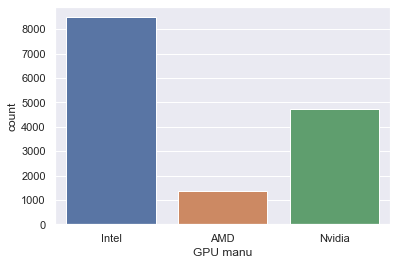

In [424]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="GPU manu", data=further_analysis)

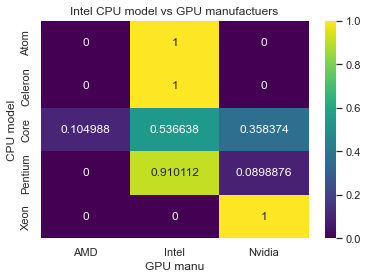

In [425]:
contigency= pd.crosstab(further_analysis['CPU model'], further_analysis['GPU manu'],normalize='index')
sns.heatmap(contigency, annot=True, fmt="g", cmap='viridis')
plt.title("Intel CPU model vs GPU manufactuers")
plt.show()


### Background Information 

Xeon -> mainly used for server chips 

Core -> Currently the most popular CPU in the market

Pentium -> used for light office work 

Celeron -> also used for light office work but generally lower in specifications and price 

Atom -> small and power efficient chips used to in netbooks (The marketing term netbook identified small and inexpensive laptops ) 


Nvidia in the GPU market has always been the better performer which also cost more .


### Based on analysing the contigency table 
#### What we see
- All of Xeon lineup uses Nvidia GPU 
- Intel core cpu has the more variety consisting of amd nvidia and intel's integrated graphics
- Intel core cpu have the second largest percentage of nvidia gpu 
- Intel Pentium has a much lower percent of nvidia gpu 
- both celeron and atom uses the integrated gpu 


# Hard Disk feature extraction
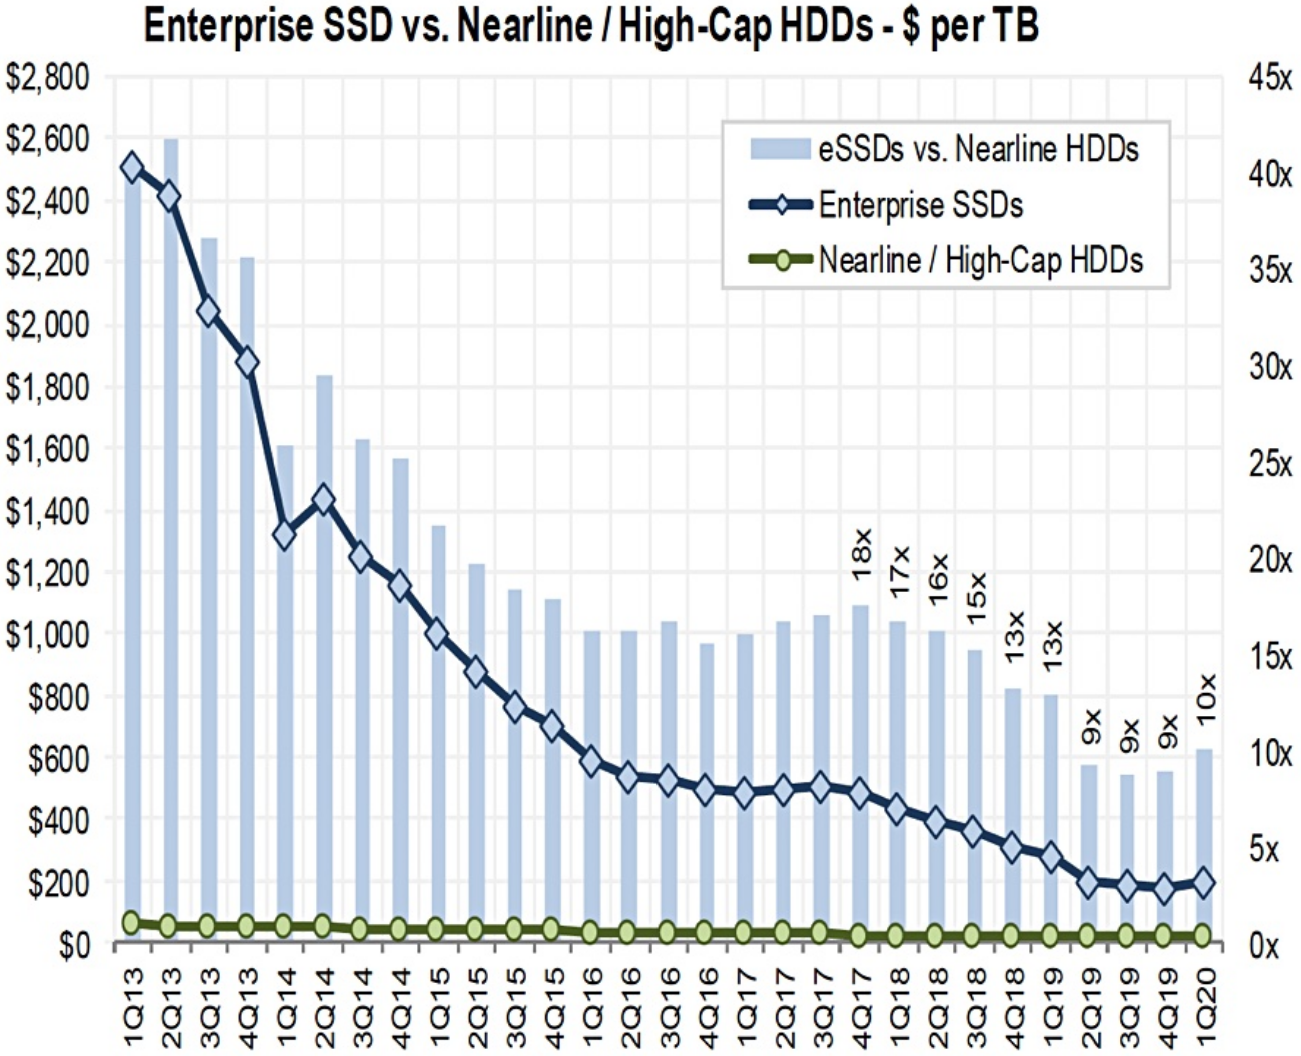

it can be seen that price of SSD --> Solid State drive is more expensive than harddrive , so it is not enough to just to extract the storage space as prices between the types of storage have an large impact on the price based on the image attached.

In this question there's 4 types of storage .
- HDD --> hard disk drive
- SSD --> solid state drive 
- flash drive
- hybrid drive 
    

In [426]:
data['HDD']=data['Hard Disk'].str.extract('(\d\d\d?GB\sHDD|\dTB\sHDD|\d\.0TB\sHDD)',expand=True)
data['HDD']=data['HDD'].str.extract('(\d\d\d?|\dTB|\d\.0TB)',expand=True)
data['HDD']=data['HDD'].str.replace('(TB|\.0TB)','000',regex=True)
data['HDD'].fillna(0,inplace=True)

data['SSD']=data['Hard Disk'].str.extract('(\d\d?\d?GB\sSSD|\dTB\sSSD|\d\.0TB\sSSD)',expand=True)
data['SSD']=data['SSD'].str.extract('(\dTB|\d\d?\d?|\d\.0TB)',expand=True)

data['SSD']=data['SSD'].str.replace('(TB|\.0TB)','000',regex=True)
data['SSD'].fillna(0,inplace=True)


In [427]:


#SSHD 

data['SSHD']=data['Hard Disk'].str.extract('(\d\d\dGB\sHybrid|\d\.0TB\sHybrid)',expand=True)
data['SSHD']=data['SSHD'].str.extract('(\d\d\d?|\d\.0TB)',expand=True)
data.loc[data['Hard Disk'].str.contains('(\d\d\dGB\sHybrid|\d\.0TB\sHybrid)',regex=True)]
data['SSHD']=data['SSHD'].str.replace('(TB|\.0TB)','000',regex=True)
data['SSHD'].fillna(0,inplace=True)



#Flash Storage
data['FStorage']=data['Hard Disk'].str.extract('(\d\d\d?GB\sFlash)',expand=True)
data['FStorage']=data['FStorage'].str.extract('(\d\d\d?)',expand=True)
data['FStorage'].fillna(0,inplace=True)

# Based on analysis , in the Hard Disk column 
there's a unique combination with is ssd + ssd 
so i need to implement a program to add them together

In [428]:

for i,j in data[data['Hard Disk'].str.contains('(\d\d\dGB\sSSD\s\+\s\s\d\d\dGB\sSSD)',regex=True)].iterrows():
    data.at[i,'SSD'] = int(j["Hard Disk"].split()[0].replace("GB",''))  +  int(j["Hard Disk"].split()[-2].replace("GB",''))
    #int(j["Hard Disk"].split()[0].replace("GB",''))  +  int(j["Hard Disk"].split()[-2].replace("GB",''))
    

In [429]:
data['GPU_brand'] = data['GPU'].apply(lambda x: x.split()[0])
data['GPU_model'] = data['GPU'].apply(lambda x: x.split()[1])

# Shld i one encode the GPU and CPU
Both have high cardinality

-- some cpu have are for mobile devices , some is high end desktop cpu 

-- the same also goes for GPU 

If i use one hot encoding to encode the GPU and CPU there will be a large influx of dimenshions in my dataset
This might lead to curse of dimensionality which would increase gpu running times and affect model performance as it is prone to overfitting.

But there are also pros to not removing such as based on looking at the number of unique number of GPU and CPU models .
110 for GPU and 118 for CPU out of 15000 records . some generalisation can be made.

In the end i decided to try both out and seem which one offers a better R2 value , 
mean_squared_error and mean absolute error

In [430]:
numeric_features = ['HDD','SSD','SSHD','FStorage']
for feature in numeric_features:
    data[feature] = pd.to_numeric(data[feature])

<AxesSubplot:xlabel='Price ($)', ylabel='Count'>

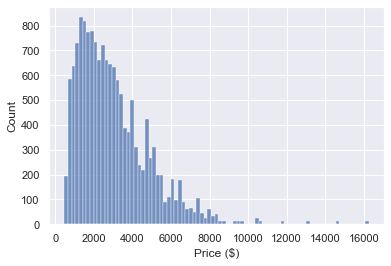

In [431]:
sns.histplot(data=data, x="Price ($)")

In [432]:
data_changed = data.copy(deep=True)

In [433]:
data_changed["Price ($)"] = data["Price ($)"].apply(lambda x : np.log(x))

<AxesSubplot:xlabel='Price ($)', ylabel='Count'>

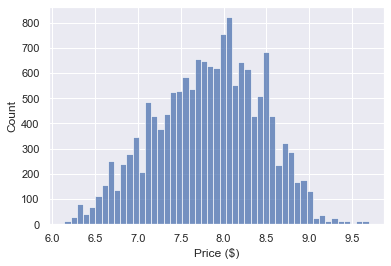

In [434]:
sns.histplot(data= data_changed, x="Price ($)")

### Doing a log normal transformation 
This will transform it into a log normal distribution 
 
This will benefit the model as Models like LDA, Gaussian Naive Bayes, Logistic Regression, Linear Regression, etc., are explicitly calculated from the assumption that the distribution is a bivariate or multivariate normal.

# Futher Exploratory Data Dnalysis


In [435]:
from matplotlib import pyplot as plt
import seaborn as sns



<AxesSubplot:xlabel='Brand', ylabel='count'>

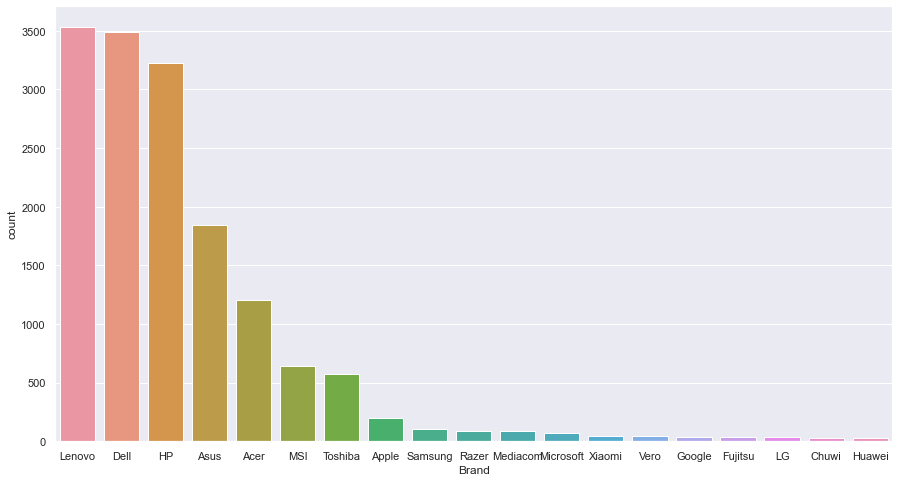

In [436]:
plt.figure(figsize=(15,8))
sns.countplot(x="Brand", data=data,
              order = data['Brand'].value_counts().index)

<AxesSubplot:xlabel='Type', ylabel='count'>

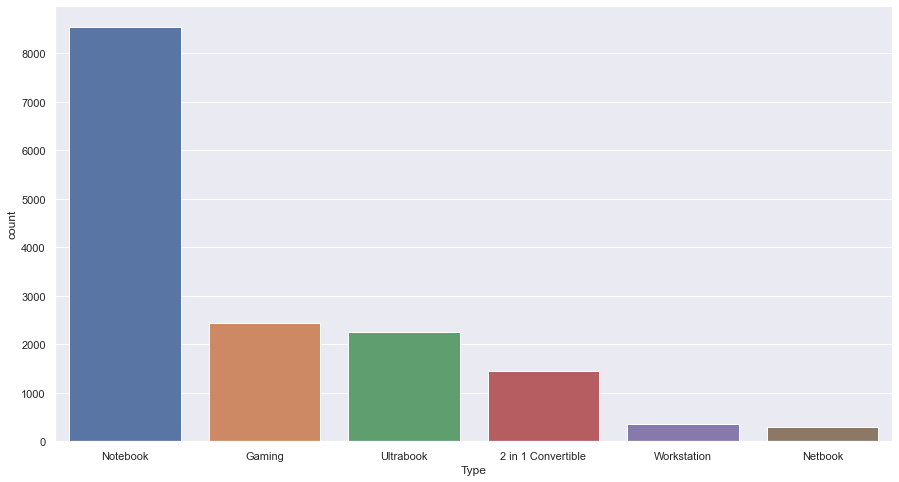

In [437]:
plt.figure(figsize=(15,8))
sns.countplot(x="Type", data=data,order = data['Type'].value_counts().index)

In [514]:
data.groupby("Type").mean()

Screen Size        RAM    Weight    Price ($)  \
Type                                                                
2 in 1 Convertible    13.615278   8.666667  1.545397  3434.829242   
Gaming                16.343257  14.085526  2.952998  4630.875230   
Netbook               11.818919   4.675676  1.310405  1716.773135   
Notebook              15.326451   6.512172  2.059167  2101.293880   
Ultrabook             13.584425   9.405310  1.336694  4140.522353   
Workstation           15.951724  10.482759  2.466552  6080.732951   

                          X_res        Y_res       IPS  Touchscreen  \
Type                                                                  
2 in 1 Convertible  2129.933333  1203.800000  0.538889     0.983333   
Gaming              2049.473684  1152.828947  0.430921     0.024671   
Netbook             1455.837838   818.594595  0.162162     0.081081   
Notebook            1745.169476   982.089888  0.159644     0.026685   
Ultrabook           2160.318584  1240.722124  0.414159     0.233628   
Workstation         2173.793103  1222.758621  0.379310     0.068966   

                    cpu frequency         HDD         SSD       SSHD  \
Type                                                                   
2 in 1 Convertible       2.133444  126.388889  278.422222   0.000000   
Gaming                   2.722204  855.263158  236.460526  19.736842   
Netbook                  1.672703    0.000000  110.918919   0.000000   
Notebook                 2.217678  463.005618  117.956929  10.544944   
Ultrabook                2.296283   23.893805  316.120354   0.000000   
Workstation              2.748276  189.655172  264.275862   0.000000   

                     FStorage  
Type                           
2 in 1 Convertible   5.422222  
Gaming               0.000000  
Netbook             15.135135  
Notebook             2.014981  
Ultrabook           15.858407  
Workstation          2.206897

<AxesSubplot:xlabel='RAM', ylabel='count'>

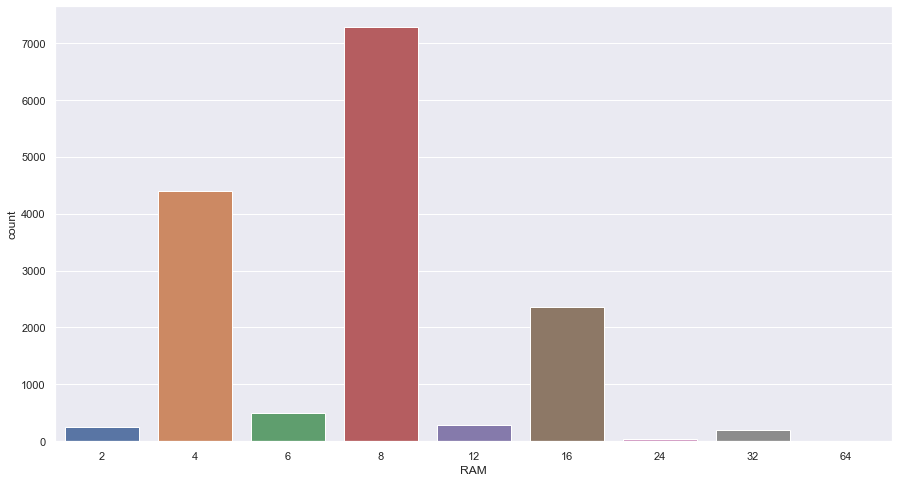

In [438]:
plt.figure(figsize=(15,8))
sns.countplot(x="RAM", data=data)

<AxesSubplot:xlabel='Screen Size', ylabel='count'>

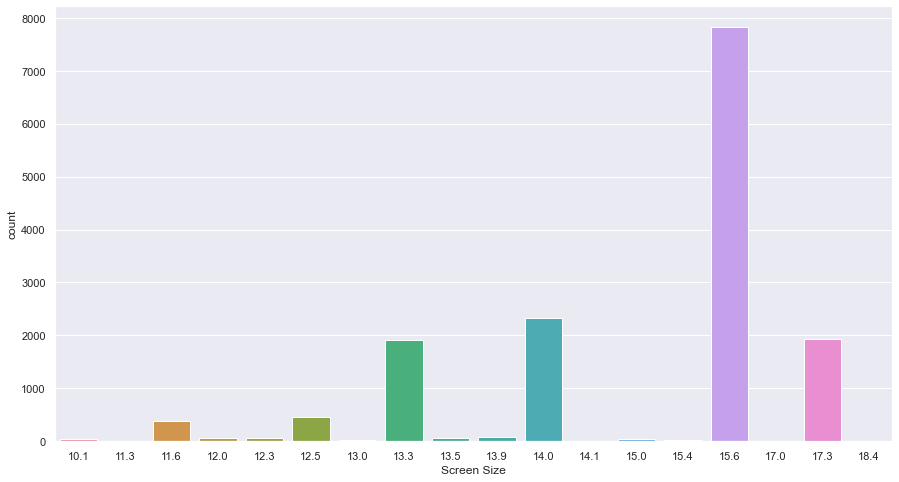

In [439]:
plt.figure(figsize=(15,8))
sns.countplot(x="Screen Size", data=data)

### Based on the countplot of the Screen Size , I can conclude 

The most common screeen size is 15.6 , 14 , 17.3 ...

This is weird because Desktop usually is paired with a larger display , at around 24 inch but this display size is not included as a option.

### Making use of Pandas-profiling to find features that contains insights

Pandas profiling is an open source library that contains EDA tools to understand our data better

The aim to is to see which features are correlated with our target variable price and understand the relationship between them.



In [487]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data)
profile.to_file("report.html")

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Price ($)', ylabel='Screen Size'>

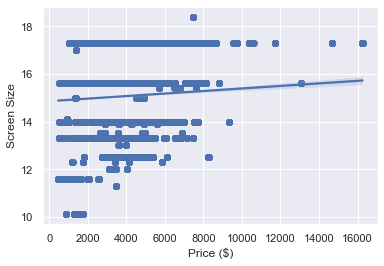

In [444]:
sns.regplot(data=data, x="Price ($)", y="Screen Size")

<AxesSubplot:xlabel='Price ($)', ylabel='RAM'>

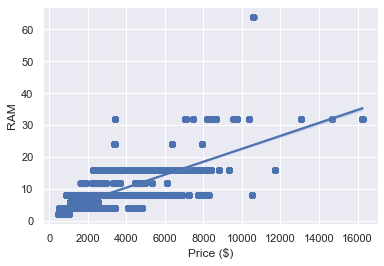

In [445]:
sns.regplot(data=data, x="Price ($)", y="RAM")

<AxesSubplot:xlabel='Price ($)', ylabel='RAM'>

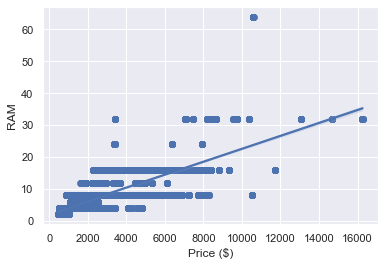

In [446]:
sns.regplot(data=data, x="Price ($)", y="RAM")

<AxesSubplot:xlabel='Price ($)', ylabel='Weight'>

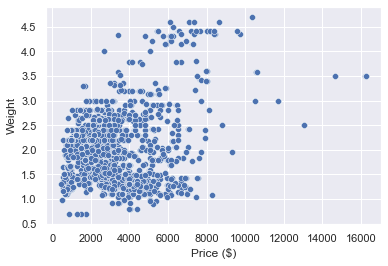

In [447]:
sns.scatterplot(data=data, x="Price ($)", y="Weight")

<AxesSubplot:xlabel='Price ($)', ylabel='cpu frequency'>

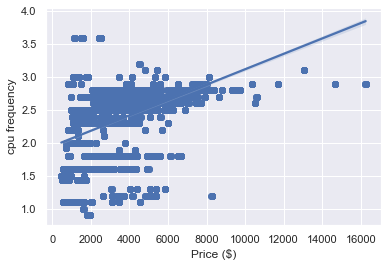

In [448]:
sns.regplot(data=data, x="Price ($)", y="cpu frequency")

<AxesSubplot:xlabel='Price ($)', ylabel='SSD'>

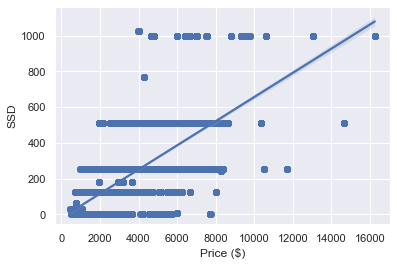

In [449]:
sns.regplot(data=data, x="Price ($)", y="SSD")

<AxesSubplot:xlabel='Price ($)', ylabel='HDD'>

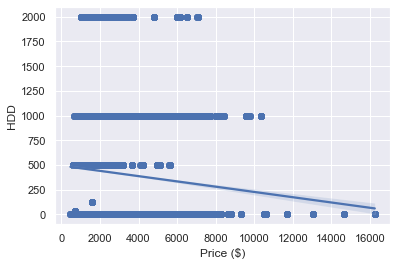

In [450]:
sns.regplot(data=data, x="Price ($)", y="HDD")

### Conclusion after Anaysing the relationship between Target variable and the features 

There are some features that are correlated to such as screen size, ram , cpu frequency and SSD. 
The ones that stand out is screen size , ram and SSD where they have a high correlation and could have a strong impact on predicting pc price.

Other features like HDD and weight tells a different story 

HDD seems to be negative correlated with the price of the target variable but a negative correlation . HDD also known as hard drive is a much older and slower technology compared to SSD -- solid state drive which is a more recent techology and offers higher speeds. Therefore computers that are have HDD is more likely to be cheaper .

Weight is an interesting features as in laptops and computers there's two extremes.
Based on background knowledge about computer, a better CPU or GPU will use up more power which would require a better cooling system that involves Copper heatsinks and fans which is often reflected in the weight of the Computer. 

Some Computers with premium built quality such as Apple's Macbook which uses an aluminum chassy also carries more weight , whereas the cheaper computers have a worse built quality by replacing metals with plastic , reducing the weight and price. 

However , there's excepts to this generalisation which would be another category of laptops that focuses on the weight of the laptop instead of built quality and performance . The materials they use are often duarable and light such as carbon fibre .


This explains the irregularity between the price and weight

## Checking for correlation between the variables 

in checking collinearity between the variables i decided to use 2 different graphs to assist me

first is correlation plot using spearman method which is used to check for linear correlations

secondly , i will be using phik correlation plot to check for non linear trends that i have missed . 

In [451]:
data = data.drop(["Product ID"],axis = 1)

<AxesSubplot:>

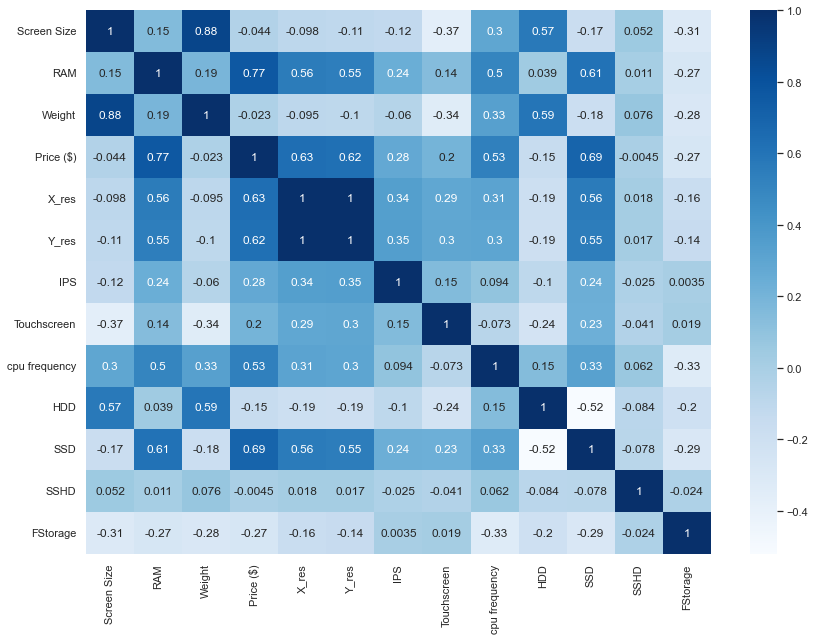

In [452]:
plt.figure(figsize=(14,10))
sns.heatmap(data.corr(method='spearman'),cmap='Blues', annot=True)

In [453]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [454]:
phik_overview = data.phik_matrix()

interval columns not set, guessing: ['Screen Size', 'RAM', 'Weight', 'Price ($)', 'X_res', 'Y_res', 'IPS', 'Touchscreen', 'cpu frequency', 'HDD', 'SSD', 'SSHD', 'FStorage']


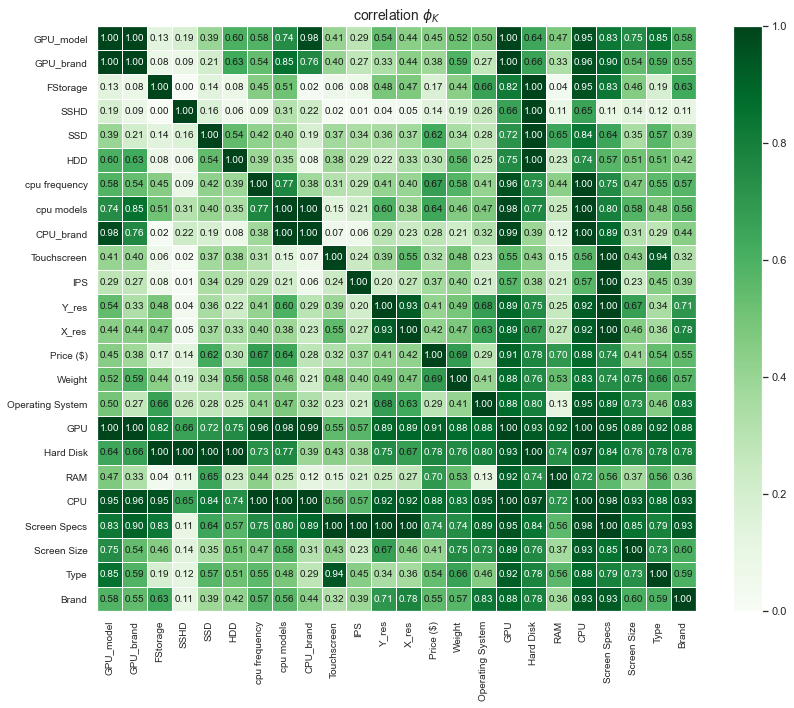

In [455]:

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(12,10))
plt.tight_layout()

## Conclusion after analysing both 

After analysing the phik correlation plot and correlation plot there's a few things to notice . Almost all the correlation between price and other variables have increased most notably screen specs , weight .Indicating that there's alot of none linear relationships between the variables .

From the phik correlation i notice that CPU , GPU these variables with high cardinality seems to have a very high correlation with the price. 

I will investigate this further on .

# Regression without cpu and gpu 
## but extracted information that has a low cardinality

some of these information include cpu_brand , cpu_model ,cpu frequency,GPU_brand,GPU_model

In [456]:
columns_drop = ["Hard Disk","Screen Specs","CPU","GPU"]

In [457]:
data_drop = data.drop(columns_drop,axis = 1)

In [458]:
X,y = data_drop.drop(["Price ($)"],axis = 1),data['Price ($)']
# split dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20)


In [459]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler,LabelBinarizer,PowerTransformer,OneHotEncoder

onehot_features = ["Operating System","Brand","Type","CPU_brand","cpu models","GPU_brand","GPU_model",]
scaling_features = ["Screen Size","Weight","X_res","cpu frequency","Y_res","HDD","SSD","SSHD","FStorage","RAM"]

num_features_pipe = Pipeline([
    ("scaler", StandardScaler())
])
cat_features_pipe = Pipeline([
    ("Ordinal_encoding",OneHotEncoder())
])


drop_CPU_GPU_pipe = ColumnTransformer([
    ("cat", cat_features_pipe, onehot_features),
    ("num", num_features_pipe, scaling_features)
    
],remainder = 'passthrough')

In [460]:
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [461]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.compose import TransformedTargetRegressor

def models_selection(clfs:list, X_train, y_train,prep_pipe, table_name = "Model Score",
                     scoring=[mean_squared_error, mean_absolute_error, r2_score],
                     columns = ["mse", "mae", "r2"], trainvstest = True,
                     graph = False, rmse = True, return_table = False):
    hist = {}
    model_names = []
    for idx, model in tqdm(enumerate(models)):
        try:
            
            ok = Pipeline([
                ("preprocess", prep_pipe),
                ("model",model())
            ])
            clf = TransformedTargetRegressor(regressor=ok, func=np.log, inverse_func=np.exp)
        except:
            ok = model()
            clf = TransformedTargetRegressor(regressor=ok, func=np.log, inverse_func=np.exp)
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        mse_train = mean_squared_error(y_train, yhat_train)
        mae_train = mean_absolute_error(y_train, yhat_train)
        r2_score_train = r2_score(y_train, yhat_train)
        # 5-Fold CV
        cv_hist = cross_validate(clf, X_train, y_train, scoring=["neg_mean_squared_error", "neg_mean_absolute_error", "r2"], n_jobs=-1)
        hist[model.__name__] = dict(
            train_mse = mse_train,
            cv_mse = abs(cv_hist['test_neg_mean_squared_error'].mean()),
            train_mae = mae_train,
            cv_mae = abs(cv_hist['test_neg_mean_absolute_error'].mean()),
            train_r2 = r2_score_train,
            cv_r2 = cv_hist['test_r2'].mean(),
        )
    df = pd.DataFrame(hist).T
    df.style.set_table_attributes("style='display:inline'").set_caption(table_name)   
    display(df)

In [462]:
models = [
    LinearRegression, Lasso, Ridge, #linear_model
    KNeighborsRegressor, #distance_based_model
    SVR,
    DecisionTreeRegressor, #tree model
    RandomForestRegressor, #ensemble tree models
    GradientBoostingRegressor 
]
models_selection(models, X_train, y_train,table_name = "Regression without cpu and gpu",prep_pipe=drop_CPU_GPU_pipe )

8it [01:47, 13.41s/it]


train_mse        cv_mse    train_mae  \
LinearRegression           1.058630e+06  1.092569e+06   610.457844   
Lasso                      3.751320e+06  3.752718e+06  1395.746499   
Ridge                      1.055290e+06  1.089020e+06   611.585462   
KNeighborsRegressor        9.861570e+03  1.567852e+04    23.565973   
SVR                        1.761503e+05  1.882326e+05   297.209996   
DecisionTreeRegressor      8.674072e+03  9.532297e+03    23.164642   
RandomForestRegressor      8.661306e+03  9.634791e+03    23.292103   
GradientBoostingRegressor  3.795511e+05  3.902712e+05   421.647265   

                                cv_mae  train_r2     cv_r2  
LinearRegression            614.625852  0.697052  0.690088  
Lasso                      1396.068179 -0.073516 -0.074049  
Ridge                       615.761215  0.698007  0.691047  
KNeighborsRegressor          34.527006  0.997178  0.995538  
SVR                         306.105652  0.949591  0.945988  
DecisionTreeRegressor        24.605806  0.997518  0.997262  
RandomForestRegressor        25.909450  0.997521  0.997234  
GradientBoostingRegressor   429.209150  0.891384  0.888240

# Regression with cpu and gpu 
## did not extract infomation out of cpu,gpu and binary encoded it 

In [463]:
data_filtered = data.drop(['CPU_brand',"cpu models","cpu frequency","GPU_brand","GPU_model","Hard Disk"],axis = 1)

In [464]:
from sklearn.preprocessing import LabelBinarizer

class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly,self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

In [465]:
# New pipeline for binary encoding

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler,LabelBinarizer,PowerTransformer,OneHotEncoder

onehot_features = ["Operating System","Brand","Type"]
hashing_features = ["CPU","GPU"]
scaling_features = ["Screen Size","Weight","X_res","Y_res","HDD","SSD","SSHD","FStorage","RAM"]

num_features_pipe = Pipeline([
    ("scaler", StandardScaler())
])


cat_features_pipe = Pipeline([
    ("onehot",OneHotEncoder())
])

hasing_features_pipe = Pipeline([
    ("binary_encoding",(LabelBinarizerPipelineFriendly()))
])


hash_CPU_GPU_pipe = ColumnTransformer([
    ("binaryencodingCPU",hasing_features_pipe,'CPU'),
    ("binaryencodingGPU",hasing_features_pipe,"GPU"),
    ("cat", cat_features_pipe, onehot_features),
    ("num", num_features_pipe, scaling_features)
    
],remainder = 'passthrough')

# Explain preprocessing 

For features that have lesser unique values like operating system , brand and type i can simply one hot encode .

For this dataset I used a another categorical encoding method called binary encoding where it's uses binary numbers to encode the data . This is an more efficient manner as unlike other methods like one hot encoding or dummyencoder it uses significantly less space which helps in reducing the dimension of the data and improve model efficiency.CPU and GPU have a high cardinality of around 120 respectively .For features that has a lower number of unique values there's no point for binary encoding as it is already small in dimension.

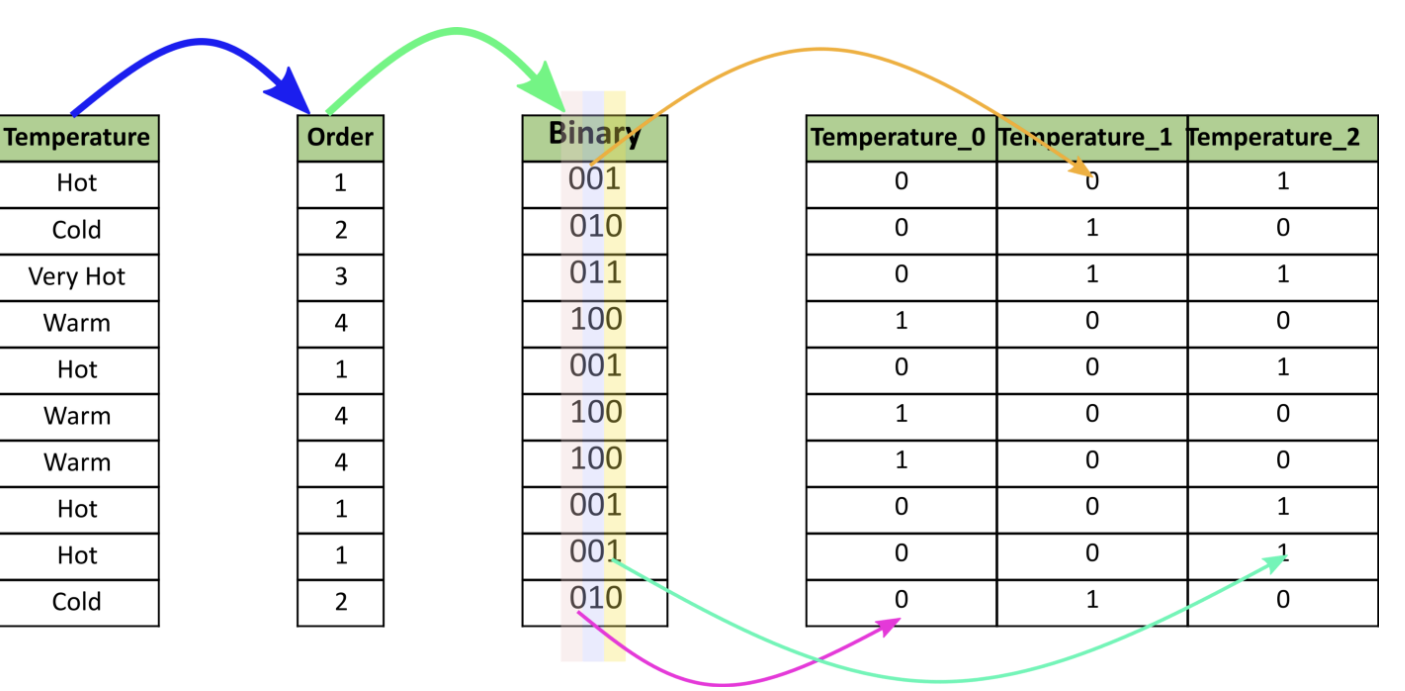

Next i added a TargetTransformer which is a function that applies a logarithmic scaling to the features to make it normal. 
THis is useful as Models like LDA, Gaussian Naive Bayes, Logistic Regression, Linear Regression, etc., are explicitly calculated from the assumption that the distribution is a bivariate or multivariate normal. 

In [466]:
drop_columns = ['CPU_brand','cpu models','cpu frequency','GPU_brand','GPU_model','Screen Specs',"Hard Disk"]
original_data = data.drop(drop_columns,axis = 1)


In [467]:
X,y = original_data.drop(["Price ($)"],axis = 1),original_data['Price ($)']
# split dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20)

In [468]:
from xgboost import XGBRegressor

In [469]:
models = [
    LinearRegression, Lasso, Ridge, #linear_model
    KNeighborsRegressor, #distance_based_model
    SVR,
    DecisionTreeRegressor, #tree model
    RandomForestRegressor, #ensemble tree models
    GradientBoostingRegressor,
    XGBRegressor
    
]
models_selection(models,X_train, y_train,,table_name = "Regression with cpu and gpu",prep_pipe=hash_CPU_GPU_pipe )

9it [01:54, 12.73s/it]


train_mse        cv_mse    train_mae  \
LinearRegression           4.229956e+05  4.340633e+05   414.316100   
Lasso                      3.778871e+06  3.779829e+06  1402.750039   
Ridge                      4.327531e+05  4.469035e+05   422.330069   
KNeighborsRegressor        2.990446e+03  7.519284e+03    14.301595   
SVR                        1.068573e+05  1.126876e+05   249.071508   
DecisionTreeRegressor      2.772273e+03  3.174592e+03    13.989545   
RandomForestRegressor      2.776176e+03  3.260782e+03    14.072167   
GradientBoostingRegressor  4.373891e+05  4.624795e+05   458.459366   
XGBRegressor               6.098356e+04  7.296698e+04   161.378986   

                                cv_mae  train_r2     cv_r2  
LinearRegression            419.952822  0.879820  0.876614  
Lasso                      1403.054793 -0.073637 -0.074409  
Ridge                       430.297463  0.877048  0.872965  
KNeighborsRegressor          24.574018  0.999150  0.997846  
SVR                         253.233423  0.969640  0.967943  
DecisionTreeRegressor        15.114866  0.999212  0.999099  
RandomForestRegressor        16.524939  0.999211  0.999074  
GradientBoostingRegressor   469.964677  0.875731  0.868529  
XGBRegressor                177.205782  0.982674  0.979241

## Based on Evaluation on MAE score 

DecisionTree,RandomForest,Gradient and KNN regressor performs very well compared to other models .
With a Cross Validation Mean absolute error of 28.442

lineary model like lasso , linear regression and ridge regression seem to perform very badly , this is due to the model not being able understand the none linear relationships between the variables.



# Model evaulation


In [470]:
def model_evaluation(clf, X_train, y_train,X_test,  y_test, scoring=[mean_squared_error, mean_absolute_error, r2_score],
                     columns = ["mse", "mae", "r2"], trainvstest = True ,graph = True, rmse = True, return_table = True, log=False):
        hist = []
        pred_train = clf.predict(X_train)
        pred_test = clf.predict(X_test)
        
        
        if log: # if y label is log scaled
            y_train = np.exp(y_train) # Inverse Log Scale for training data
            pred_train = np.exp(pred_train) # Inverse of Log Scale for training set
            pred_test = np.exp(pred_test) # Inverse of Log Scale for training set
        
        for score in scoring:
            if rmse and score == mean_squared_error:
                if trainvstest: # if compare both train and test set
                   hist.append(round(score(y_train, pred_train, squared=False),2))
                hist.append(round(score(y_test, pred_test, squared=False),2))
                continue
            if trainvstest:
                hist.append(round(score(y_train, pred_train),2))
            hist.append(round(score(y_test, pred_test),2))
        cols = columns.copy()
        if rmse:
            try:
                cols[cols.index("mse")] = 'rmse'
            except:
                assert False,"Mean Squared Error is missing from columns"
            
        if trainvstest:
            cols = np.array([["train_"+col, "test_"+col] for col in cols]).flatten()
        
        if graph:
            fig, ax = plt.subplots(figsize=(7,7))
            plt.scatter(y_test, pred_test, c='crimson')
            p1 = max(max(pred_test), max(y_test))
            p2 = min(min(pred_test), min(y_test))
            plt.plot([p1, p2], [p1, p2], 'b-')
            plt.xlabel('True Values', fontsize=15)
            plt.ylabel('Predictions', fontsize=15)
            ax.set_aspect('equal')
            plt.show()
            
        if return_table:
            return pd.DataFrame([hist], columns=cols, index = [type(clf).__name__])
        else:
            return type(clf).__name__, hist, cols

In [471]:
#tune tree hyper parameters
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, learning_curve ,HalvingGridSearchCV

# Code to plot learning curve 
to check if model is over or underfitting

In [472]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit



def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring= "neg_mean_absolute_error",
        cv = 5,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    # Plot learning curve

    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times

    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]

    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

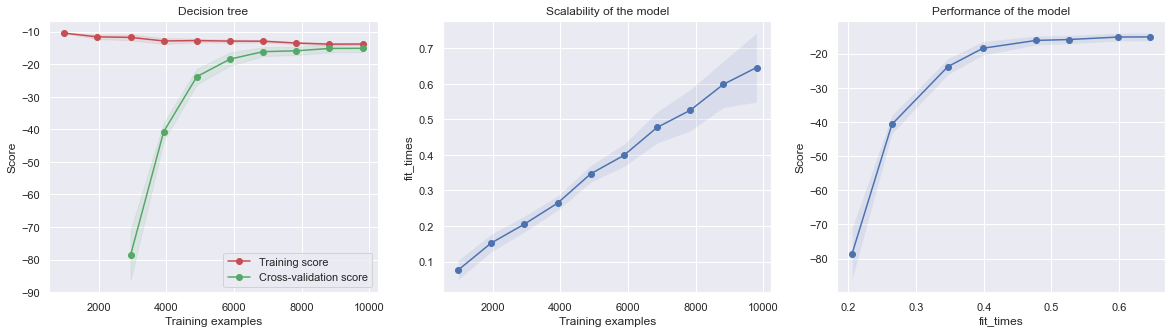

In [474]:
from sklearn.pipeline import Pipeline

regression_decision_tree = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",DecisionTreeRegressor())
            ])
regpipline = TransformedTargetRegressor(regressor=ok, func=np.log, inverse_func=np.exp)

plot_learning_curve(regression_decision_tree,"Decision tree",
                    X_train,y_train,n_jobs=-1,
                    train_sizes=np.linspace(0.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

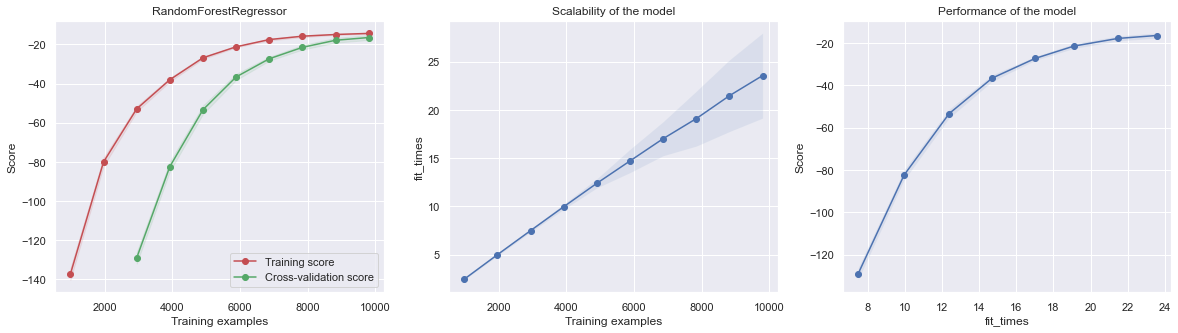

In [475]:
regression_decision_tree = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",RandomForestRegressor())
            ])

regression_decision_tree = TransformedTargetRegressor(regressor=regression_decision_tree, func=np.log, inverse_func=np.exp)
plot_learning_curve(regression_decision_tree,"RandomForestRegressor",
                    X_train,y_train,n_jobs=-1,
                    train_sizes=np.linspace(0.1, 1.0, 10))

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

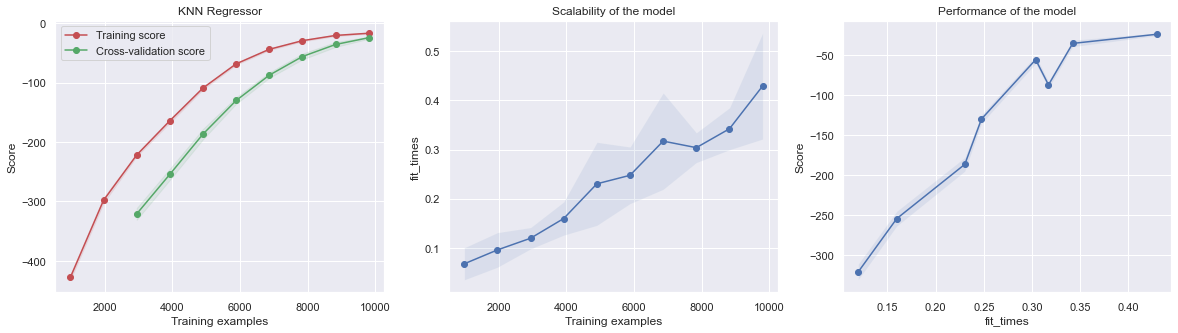

In [476]:
regression_knn = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",KNeighborsRegressor())
            ])
regression_knn = TransformedTargetRegressor(regressor=regression_knn, func=np.log, inverse_func=np.exp)
plot_learning_curve(regression_knn,"KNN Regressor",
                    X_train,y_train,n_jobs=-1,
                    train_sizes=np.linspace(0.1, 1.0, 10))

## Based on analysing the learning curve

There's a lower variance for the cross validation score across all the models . 
The models could benefit from more data because it is converging at a very high value 

For Decision Tree Regressor it converges at a score of -27 neg_mean_absolute_error

For KNN Regressor and Random Forest Regessor as the amount of training data increases both training and cross validation score increases together.

## Hyperparameter Tunning

next i will be picking the top performers and tunning it's parameters in order to achieve a higher MAE score and improve the underfit and overfit situation

# Decison Tree Regressor

In [491]:
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

regression_decision_tree = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",TransformedTargetRegressor(DecisionTreeRegressor(),func=np.log,inverse_func=np.exp))
            ])


param_grid = {
              'model__regressor__splitter':["best","random"],
              'model__regressor__max_features':['auto','sqrt','log2',None],
              'model__regressor__min_samples_split':np.arange(2,5),
              'model__regressor__max_depth':np.arange(50,120,2),
    
             }
grid_search = HalvingGridSearchCV(estimator=regression_decision_tree,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'model__regressor__max_depth': 78,
 'model__regressor__max_features': 'auto',
 'model__regressor__min_samples_split': 2,
 'model__regressor__splitter': 'best'}

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

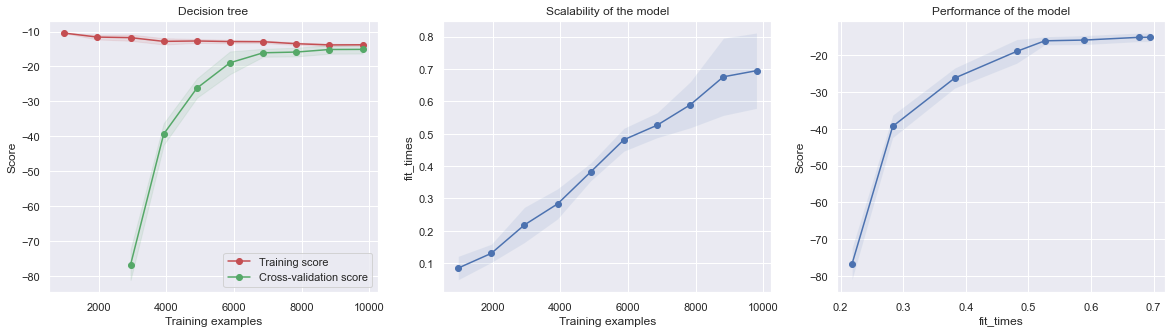

In [492]:
regression_decision_tree = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",TransformedTargetRegressor(DecisionTreeRegressor(
                                               max_depth = 78,
                                               min_samples_split = 2,
                                               splitter = 'best'),func=np.log,inverse_func=np.exp))
            ])
#ok = TransformedTargetRegressor(regression_decision_tree,func=np.log,inverse_func=np.exp)
plot_learning_curve(regression_decision_tree,"Decision tree",
                    X_train,y_train,n_jobs=-1,
                    train_sizes=np.linspace(0.1, 1.0, 10))

In [479]:
from sklearn.model_selection import cross_val_score
regression_decision_tree = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",TransformedTargetRegressor(DecisionTreeRegressor(
                                               max_depth = 66,
                                               min_samples_split = 2,
                                               splitter = 'best'),func=np.log,inverse_func=np.exp))
            ])
score = cross_val_score(regression_decision_tree,X_train,y_train,cv = 5,scoring = 'neg_mean_absolute_error')
print("Final Cross Validation MAE Score is ",abs(score.mean()))

Final Cross Validation MAE Score is  15.114865785829982


## Conclusion after doing Hyperparameter tunning for the DecisionTree 

Even before any tunning the default parameter of 
spliter --> best
minimum sample split --> 2
max_depth --> None 

have already yield a very good result in fact the score after tunning 

I would just use the tunned parameter as it has a lower depth and there's a lower chance of overfitting the data as i limited the max depth.


# K Nearest Neighbour Regressor

In [263]:
from sklearn.model_selection import validation_curve

In [493]:

regression_decision_tree = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",TransformedTargetRegressor(KNeighborsRegressor(),func=np.log,inverse_func=np.exp))
            ])


param_grid = {
              'model__regressor__n_neighbors':np.arange(50,120,2),
              'model__regressor__weights':['uniform','distance'],
              'model__regressor__algorithm':['auto','ball_tree','kd_tree','brute']
             }
grid_search = HalvingGridSearchCV(estimator=regression_decision_tree,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'model__regressor__algorithm': 'auto',
 'model__regressor__n_neighbors': 64,
 'model__regressor__weights': 'distance'}

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

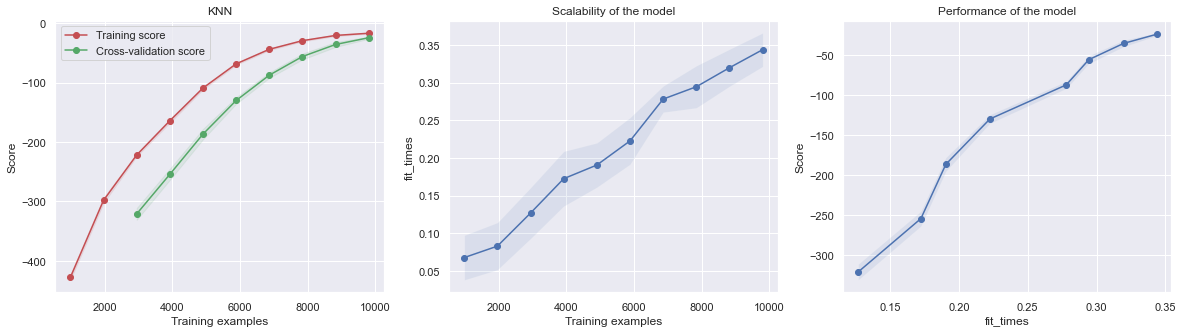

In [483]:
regression_knn = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",TransformedTargetRegressor(KNeighborsRegressor(algorithm = 'ball_tree',n_neighbors = 64,weights = 'distance'),
                                                    func=np.log,
                                                    inverse_func=np.exp))
            ])

plot_learning_curve(regression_decision_tree,"KNN",
                    X_train,y_train,n_jobs=-1,
                    train_sizes=np.linspace(0.1, 1.0, 10))

In [482]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(regression_knn,X_train,y_train,cv = 5,scoring = 'neg_mean_absolute_error',error_score="raise")
print("Final Cross Validation MAE Score is ",abs(score.mean()))

Final Cross Validation MAE Score is  15.139129808980138


# Random Forest Regressor

In [ ]:

regression_random_forest = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",TransformedTargetRegressor(RandomForestRegressor(),
                                                    func=np.log,
                                                    inverse_func=np.exp))
            ])



param_grid = {
              'model__regressor__criterion':['absolute_error'],
              'model__regressor__max_depth':np.arange(1,50,3),
              'model__regressor__min_samples_split':np.arange(2,5),
              'model__regressor__ccp_alpha':np.arange(0,0.5,0.1)
    
             }
grid_search = HalvingGridSearchCV(estimator=regression_random_forest,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
regression_random_forest = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",TransformedTargetRegressor(RandomForestRegressor(criterion= 'absolute_error',
                                                                          max_depth= 113,
                                                                          min_samples_split=2,
                                                                          ccp_alpha = 0),
                                                    func=np.log,
                                                    inverse_func=np.exp))
            ])

plot_learning_curve(regression_random_forest,"Random Forest",
                    X_train,y_train,n_jobs=-1,
                    train_sizes=np.linspace(0.1, 1.0, 10))

## Conclusion after doing Hyperparameter tunning for the K Nearest Neighbours

After hyperparameter tunning , KNN model actually performed alot better reducing the mean absolute error from 24.574018 to around 15.



# Model Improvement
to see if there's furtherpotential to improve the MAE score i decided to try  a ensemble method called stacking  

i will be using voting classifier that is made up of 3 base classifier 
Decision tree, KNN and Random Forest


In [508]:
from sklearn.ensemble import StackingRegressor
clf1 = KNeighborsRegressor(algorithm = 'ball_tree',n_neighbors = 64,weights = 'distance')
clf2 = DecisionTreeRegressor(max_depth = 66,min_samples_split = 2,splitter = 'best')
clf3 = RandomForestRegressor()

In [509]:
voting_classifier_model = StackingRegressor(estimators=[('knn', clf1), ('rfg', clf3)],
                                            final_estimator=DecisionTreeRegressor(
                                               max_depth = 78,
                                               min_samples_split = 2,
                                               splitter = 'best'),n_jobs= -1)

In [510]:
vcm = Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",TransformedTargetRegressor(voting_classifier_model,
                                                    func=np.log,
                                                    inverse_func=np.exp))
            ])

In [511]:
vcm.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binaryencodingCPU',
                                                  Pipeline(steps=[('binary_encoding',
                                                                   LabelBinarizerPipelineFriendly())]),
                                                  'CPU'),
                                                 ('binaryencodingGPU',
                                                  Pipeline(steps=[('binary_encoding',
                                                                   LabelBinarizerPipelineFriendly())]),
                                                  'GPU'),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  

<module 'matplotlib.pyplot' from 'C:\\Users\\yuwei\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

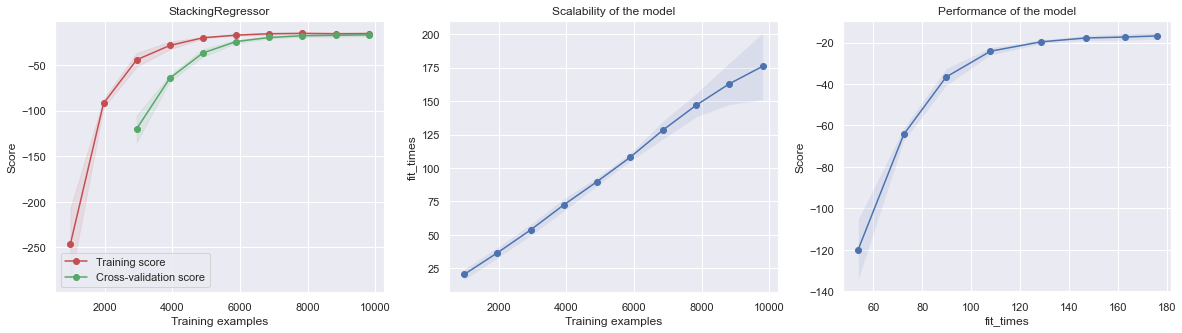

In [512]:
plot_learning_curve(vcm,"StackingRegressor",
                    X_train,y_train,n_jobs=-1,
                    train_sizes=np.linspace(0.1, 1.0, 10))

In [513]:

score = cross_val_score(vcm,X_train,y_train,cv = 5,scoring = 'neg_mean_absolute_error')
print("Final Cross Validation MAE Score is ",abs(score.mean()))

Final Cross Validation MAE Score is  16.77821862753925


## stacking using the top 3 models did not yield a better result


This might be due to the base models have alot of overlaps in the correct predictions of the ensembled model.



# Model Selection

stacking regression had a MAE score of 16.778 which is slightly behind the KNN and decision tree regressor base model.
Both models perform just as well having a MAE score of 15 processing time would be the next measure for selection. 

Since DecisionTree processing time and space complexity is much lower ,i will use Decision Tree

In [484]:
#final pipeline
onehot_features = ["Operating System","Brand","Type"]
hashing_features = ["CPU","GPU"]
scaling_features = ["Screen Size","Weight","X_res","Y_res","HDD","SSD","SSHD","FStorage","RAM"]

num_features_pipe = Pipeline([
    ("scaler", StandardScaler())
])


cat_features_pipe = Pipeline([
    ("onehot",OneHotEncoder())
])

hasing_features_pipe = Pipeline([
    ("binary_encoding",(LabelBinarizerPipelineFriendly()))
])


hash_CPU_GPU_pipe = ColumnTransformer([
    ("binaryencodingCPU",hasing_features_pipe,'CPU'),
    ("binaryencodingGPU",hasing_features_pipe,"GPU"),
    ("cat", cat_features_pipe, onehot_features),
    ("num", num_features_pipe, scaling_features)
    
],remainder = 'passthrough')

model =  Pipeline([
                ("preprocess", hash_CPU_GPU_pipe),
                ("model",TransformedTargetRegressor(DecisionTreeRegressor(
                                               max_depth = 80,
                                               min_samples_split = 3,
                                               splitter = 'random'),func=np.log,inverse_func=np.exp))
            ])



In [485]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binaryencodingCPU',
                                                  Pipeline(steps=[('binary_encoding',
                                                                   LabelBinarizerPipelineFriendly())]),
                                                  'CPU'),
                                                 ('binaryencodingGPU',
                                                  Pipeline(steps=[('binary_encoding',
                                                                   LabelBinarizerPipelineFriendly())]),
                                                  'GPU'),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  

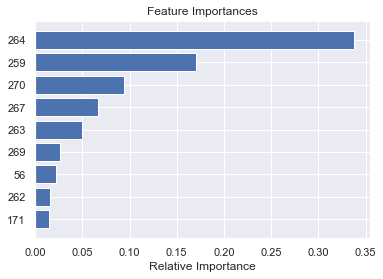

In [397]:
importances = model[1].regressor_.feature_importances_
indices = np.argsort(importances)[-9:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.show()

# Feature Importance

Based on looking at the columns to one numerical features tends to have a higher feature importance than binary encoded features like CPU and GPU . 

The feature with the highest importance is X_resolution followed by brand and RAM 

This is surprising as when humans buy Computer CPU and GPU is usually the most costly .

# Final evaluation and comparing against baseline

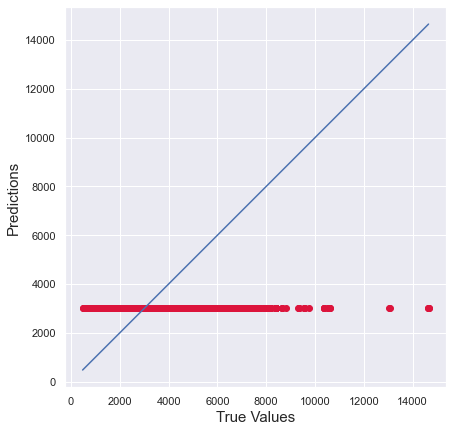

train_rmse  test_rmse  train_mae  test_mae  train_r2  test_r2
DummyRegressor     1876.08    1821.53    1436.04   1400.65       0.0     -0.0

In [473]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
model_evaluation(dummy, X_train, y_train, X_test, y_test)

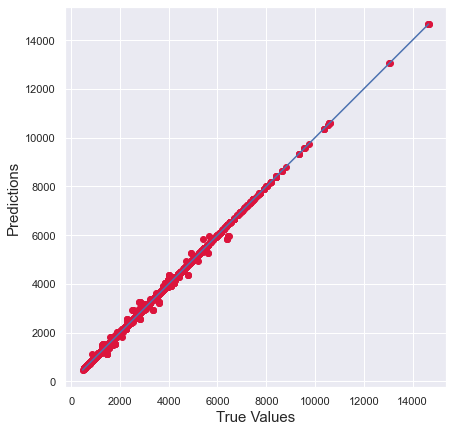

train_rmse  test_rmse  train_mae  test_mae  train_r2  test_r2
Pipeline       52.65      58.78      13.99     15.71       1.0      1.0

In [486]:

model_evaluation( model, X_train,y_train, X_test, y_test)

## Error analysis 

Based on the True Value vs Predicted plot , the model has done very well at predicting the pc prices. The model struggled for PC prices between 6000 to 8000 which are considered extreme values as it only contains 6% of the total computers.

I am surprised that the model is able to do well even for extreme outliers which is the expensive desktops .

In the End , I was able to achieve a test_mean absolute error of 15.71 and r2 score of 1

## Comparing to dummy regressor
Dummy regressor has a mean absolute error of 1400.65 and a r2 value of 0 . The decisor tree model outperformed the stupid baseline by a large margin